In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Representation of pulse trains

* *negative* integers --> length of time spent in the "0" state 
* *positive* integers --> length of time spent in the "1" state

In [13]:
def expand(wav):
    ## Expand from delta form to wav form
    ## using the signed delta convention
    expanded = []
    t = 0
    ts = []
    for width in wav:
        assert(width == int(width))
        ele = (np.sign(width)+1)/2 
        abs_width =np.abs(width)
        expanded += (abs_width+1)*[ele]
        ts += [t+i for i in range(abs_width+1)]
        t += abs_width
    return ts,expanded

def expand_new_pulse(t_start,t_width):
    assert(t_start == int(t_start))
    assert(t_width == int(t_width))
    assert(t_start >= 0)
    assert(t_width > 0)
    
    ts=[t_start]
    expanded = [0]
    
    ts+= list(range(t_start,t_start+t_width+1))
    expanded+= [1]*(t_width+1)
    
    ts.append(t_start+t_width)
    expanded.append(0)
    
    return ts, expanded

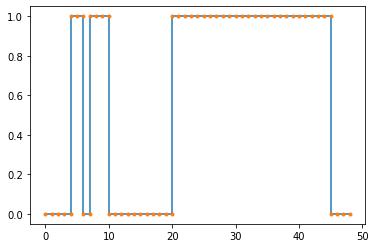

In [14]:
pulse_stream = [-4,2,-1,3,-10,25,-3]
ts,expanded = expand(pulse_stream)
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")
plt.show()

48

In [227]:
def isInt(num):
    if isinstance(num,int):
        return True
    elif isinstance(num,nested_pulse_train):
        return False
    elif np.issubdtype(num, np.integer):
        return True
    else:
        return False

from typing import Union,List
class nested_pulse_train:
    
    def __init__(self, pulses: List[Union[int,nested_pulse_train]] , verbose=True):
        self.pulses = pulses
        self.clear_zeroes()
        self.compute_duration()
        self.verbose = verbose
    def __str__(self):
        string = "nested_pulse_train( [ "
        for ele in self.pulses:
            if isInt(ele):
                string += f"{ele}, "
            else:
                string += str(ele)
        
        string += "] ) "
        return string
    
    def vprint(self,string):
        """
        avoid annoying cases to check if verbose is enabled
        """
        if self.verbose:
            print(string)
            
    def clear_zeroes(self):
        """
        nonterminal zeros must be cleared
        """
        nonterminal_zero_idxs=[idx for idx in range(len(self.pulses)) if self.pulses[idx] == 0 and idx < len(self.pulses)-1]
        #Make sure to pop from far end first
        nonterminal_zero_idxs.sort(reverse=True)
        for idx in nonterminal_zero_idxs:
            self.pulses.pop(idx)
        
        # Get all the nested pulse trains
        for pulse in [pulse for pulse in self.pulses if not isInt(pulse)]:
            pulse.clear_zeroes()
        
    
    def compute_duration(self):
        """
        Total duration of all nested pulse train components
        """
        accumulator = 0
        for ele in self.pulses:
            if isInt(ele):
                accumulator += np.abs(ele)
            else:
                accumulator += ele.compute_duration()
        self.duration = accumulator
        return self.duration
    
    def expand(self,t_offset = 0):
        """
        Return a list that is suitable for plotting pulse trains
        Do not plot, just return the lists
        """
        expanded = []
        t = t_offset
        ts = []
        for pulse in self.pulses:
            if isInt(pulse):
                ele = (np.sign(pulse)+1)/2 
                duration =np.abs(pulse)
                expanded += (duration+1)*[ele]
                ts += [t+i for i in range(duration+1)]
                t += duration
            else:
                ts_nested,expanded_nested = pulse.expand(t_offset = t)
                ts += ts_nested
                expanded += expanded_nested
                t += pulse.duration
        return ts,expanded

    
    def consolidate(self):
        """
        When nested pulse trains are all the same sign,
        they can be folded up to reduce recursion depth
        """
        sign = None
        sign_changed = False
        do_consolidate = True
        for (idx,pulse) in enumerate(self.pulses):
            
            if not isinstance(pulse,int):
                if (pulse.consolidate()):
                    self.pulses[idx] = int(pulse.pulses[0])
                    pulse = self.pulses[idx]
            
            # Initialize sign
            if sign is None:
                sign = np.sign(pulse)
            
            #if there are any sign changes, cannot fully consolidate
            if (sign != np.sign(pulse)) and (not sign_changed):
                sign_chaged = True
                do_consolidate = False
        if do_consolidate:
            self.pulses = [sign*self.duration]
            return True
        else: 
            return False
            
    def add_pulse(self,t_start: int, t_width:int):
        assert( t_start >= 0)
        
        
        for (idx,pulse) in enumerate(self.pulses):
            self.vprint(f"{idx=}, pulse={str(pulse)}, {t_start=}, {t_width=}")
            
            if t_width <= 0:
                return
            
            
            #Check if we can skip over this pulse
            if isInt(pulse):
                duration = np.abs(pulse)
            else:
                duration = pulse.duration
                
            delay = t_start-duration
            if delay >= 0:
                # Skip this <possibly nested> pulse
                t_start -= duration
            elif (delay < 0) and isinstance(pulse,nested_pulse_train):
                self.vprint(f"Recursive call of add_pulse({t_start},{t_width})")
                # recursive call on nested pulse train
                t_width = pulse.add_pulse(t_start,t_width)
                self.pulses[idx] = pulse
            elif (delay < 0) and isInt(pulse):
                # Start adding the new pulse 
                # at the current nest level in the currently iterated pulse
                
                print(f"{duration=}, {t_width=}, {delay=}, {t_start=}")
                if pulse > 0:
                    """
                    current pulse is already positive
                    decrement the t_width and move on
                    Remember that delay is *negative*
                    """ 
                    self.vprint(f"Positive pulse overlap of {delay}")
                    t_width += delay
                    t_start -= duration
                    t_start = max(0,t_start)
                elif pulse < 0:
                    """
                    current pulse is negative, must split into a positive and negative piece
                    ---  ->  ++-, new pulse eats the begining of the negative region, but terminates within (terminate)
                    ---  ->  -+-, new positive pulse is contained in negative region (terminate)
                    ---  ->  +++, new pulse consumes the negative region (continue)
                    ---  ->  -++, new positive pulse hits subseqeuent edge (continue)
                    """
                    if (t_start == 0) and (t_width < duration):
                        self.vprint("Adding ++- pulse")
                        #new pulse terminates
                        self.pulses[idx] = nested_pulse_train([t_width, t_width - duration])
                        return 0
                    elif  (t_start >0) and (t_width < -delay):
                        self.vprint("Adding -+- pulse")
                        self.pulses[idx] = nested_pulse_train([-t_start,t_width,-(-delay-t_width)])
                        # New pulse terminates within this negative region
                        return 0
                    elif (0 == t_start) and (t_width >= duration):
                        self.vprint("Adding +++ pulse")
                        self.pulses[idx] = int(np.abs(duration))
                        t_width -= duration
                    elif (t_start >0) and (t_width >= -delay):
                        self.vprint("Adding -++ pulse")
                        self.pulses[idx] = nested_pulse_train([-t_start,duration-t_start])
                        t_width -= duration-t_start 
                    else:
                        print("Unhandled pulse type.  What happend?")
            else:
                print("Unhandled main case.  What happened?")
        return t_width

nested_pulse_train( [ -10, 10, -10, 5, ] ) 
35


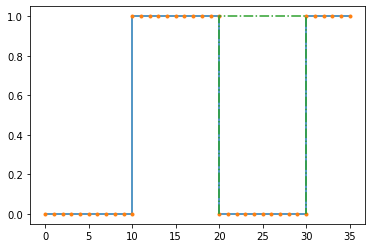

duration=10, t_width=10, delay=-10, t_start=0
Adding +++ pulse


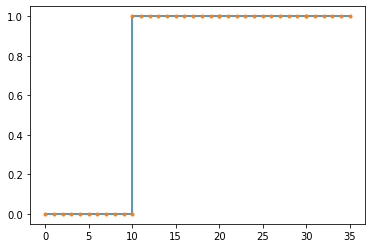

nested_pulse_train( [ -10, 10, 10, 5, ] ) 


In [195]:
example_add = nested_pulse_train( [-10,10,-10,5 ]  )
print(example_add)
example_add.compute_duration()
print(example_add.duration)
ts,expanded = example_add.expand()
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")

t_start,t_width=20,10
ts_new, expanded_new = expand_new_pulse(t_start,t_width)
plt.plot(ts_new,expanded_new,"-.")
plt.show()

example_add.add_pulse(t_start,t_width)
ts,expanded = example_add.expand()
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")
plt.show()
print(example_add)

nested_pulse_train( [ -4, 2, -1, 3, -10, 25, -3, ] ) 
48


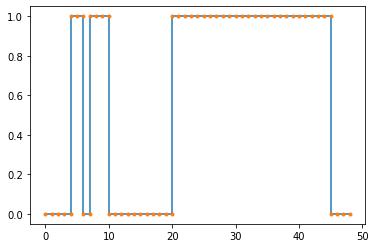

nested_pulse_train( [ -10, 10, -10, 30, nested_pulse_train( [ 2, 2, 6, -10, ] ) 10, ] ) 
90


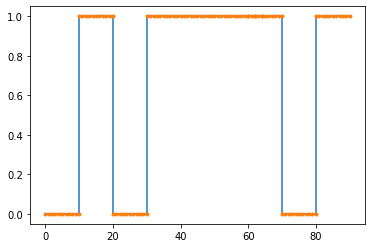

nested_pulse_train( [ -10, 10, -10, nested_pulse_train( [ 10, 10, 10, nested_pulse_train( [ 1, 1, 1, 1, ] ) ] ) 10, ] ) 
nested_pulse_train( [ -10, 10, -10, 34, 10, ] ) 


In [205]:
pulse_stream = [-4,2,-1,3,-10,25,-3]
example = nested_pulse_train(pulse_stream)
example.compute_duration()
print(example)
print(example.duration)
ts,expanded = example.expand()
example.consolidate()
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")
plt.show()

example2 = nested_pulse_train( [-10,10,-10,30, nested_pulse_train([2,2,6,-10]),10 ]  )
print(example2)
example2.compute_duration()
print(example2.duration)
ts,expanded = example2.expand()
plt.plot(ts,expanded)
plt.plot(ts,expanded,".")
plt.show()


consolidation_test = nested_pulse_train([-10,10,-10,nested_pulse_train([10,10,10,nested_pulse_train([1,1,1,1])]),10])
print(consolidation_test)
consolidation_test.consolidate()
print(consolidation_test)

CASE: 0


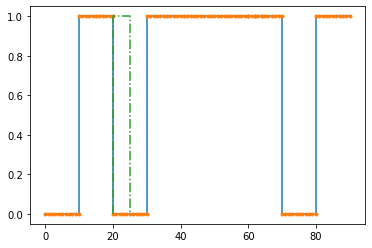

idx=0, pulse=-10, t_start=20, t_width=5
idx=1, pulse=10, t_start=10, t_width=5
idx=2, pulse=-10, t_start=0, t_width=5
duration=10, t_width=5, delay=-10, t_start=0
Adding ++- pulse


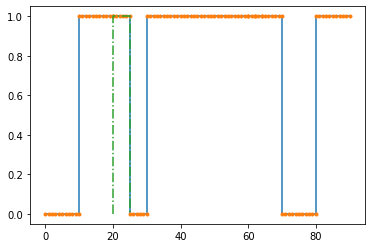

CASE: 1


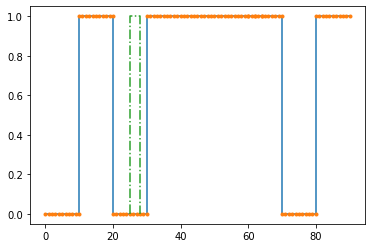

idx=0, pulse=-10, t_start=25, t_width=3
idx=1, pulse=10, t_start=15, t_width=3
idx=2, pulse=-10, t_start=5, t_width=3
duration=10, t_width=3, delay=-5, t_start=5
Adding -+- pulse


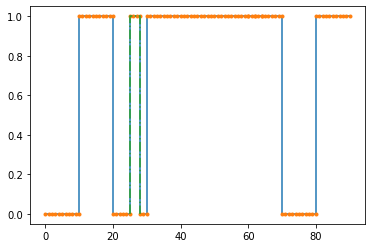

CASE: 2


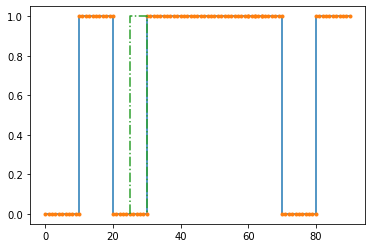

idx=0, pulse=-10, t_start=25, t_width=5
idx=1, pulse=10, t_start=15, t_width=5
idx=2, pulse=-10, t_start=5, t_width=5
duration=10, t_width=5, delay=-5, t_start=5
Adding -++ pulse
idx=3, pulse=30, t_start=5, t_width=0


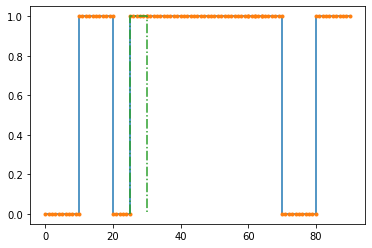

CASE: 3


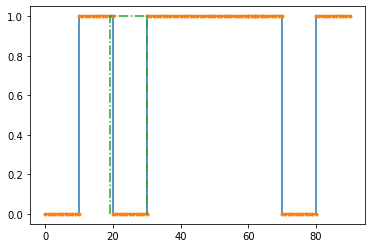

idx=0, pulse=-10, t_start=19, t_width=11
idx=1, pulse=10, t_start=9, t_width=11
duration=10, t_width=11, delay=-1, t_start=9
Positive pulse overlap of -1
idx=2, pulse=-10, t_start=0, t_width=10
duration=10, t_width=10, delay=-10, t_start=0
Adding +++ pulse
idx=3, pulse=30, t_start=0, t_width=0


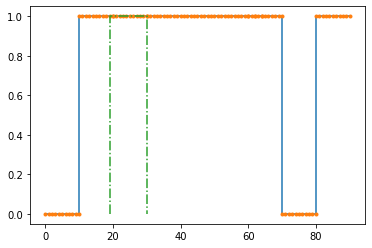

CASE: 4


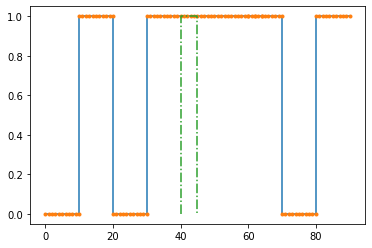

idx=0, pulse=-10, t_start=40, t_width=5
idx=1, pulse=10, t_start=30, t_width=5
idx=2, pulse=-10, t_start=20, t_width=5
idx=3, pulse=30, t_start=10, t_width=5
duration=30, t_width=5, delay=-20, t_start=10
Positive pulse overlap of -20
idx=4, pulse=nested_pulse_train( [ 2, 2, 6, -10, ] ) , t_start=0, t_width=-15


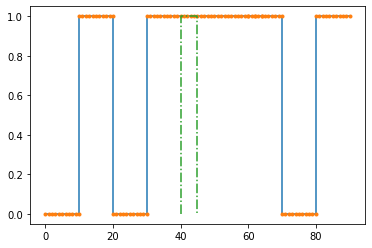

CASE: 5


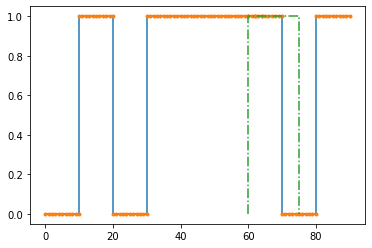

idx=0, pulse=-10, t_start=60, t_width=15
idx=1, pulse=10, t_start=50, t_width=15
idx=2, pulse=-10, t_start=40, t_width=15
idx=3, pulse=30, t_start=30, t_width=15
idx=4, pulse=nested_pulse_train( [ 2, 2, 6, -10, ] ) , t_start=0, t_width=15
Recursive call of add_pulse(0,15)
idx=0, pulse=2, t_start=0, t_width=15
duration=2, t_width=15, delay=-2, t_start=0
Positive pulse overlap of -2
idx=1, pulse=2, t_start=0, t_width=13
duration=2, t_width=13, delay=-2, t_start=0
Positive pulse overlap of -2
idx=2, pulse=6, t_start=0, t_width=11
duration=6, t_width=11, delay=-6, t_start=0
Positive pulse overlap of -6
idx=3, pulse=-10, t_start=0, t_width=5
duration=10, t_width=5, delay=-10, t_start=0
Adding ++- pulse
idx=5, pulse=10, t_start=0, t_width=0


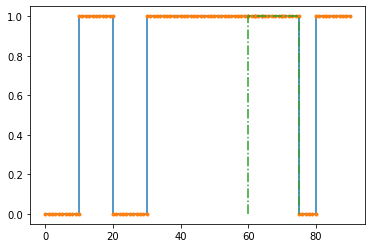

CASE: 6


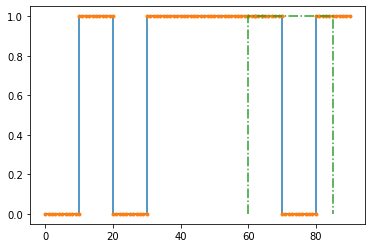

idx=0, pulse=-10, t_start=60, t_width=25
idx=1, pulse=10, t_start=50, t_width=25
idx=2, pulse=-10, t_start=40, t_width=25
idx=3, pulse=30, t_start=30, t_width=25
idx=4, pulse=nested_pulse_train( [ 2, 2, 6, -10, ] ) , t_start=0, t_width=25
Recursive call of add_pulse(0,25)
idx=0, pulse=2, t_start=0, t_width=25
duration=2, t_width=25, delay=-2, t_start=0
Positive pulse overlap of -2
idx=1, pulse=2, t_start=0, t_width=23
duration=2, t_width=23, delay=-2, t_start=0
Positive pulse overlap of -2
idx=2, pulse=6, t_start=0, t_width=21
duration=6, t_width=21, delay=-6, t_start=0
Positive pulse overlap of -6
idx=3, pulse=-10, t_start=0, t_width=15
duration=10, t_width=15, delay=-10, t_start=0
Adding +++ pulse
idx=5, pulse=10, t_start=0, t_width=5
duration=10, t_width=5, delay=-10, t_start=0
Positive pulse overlap of -10


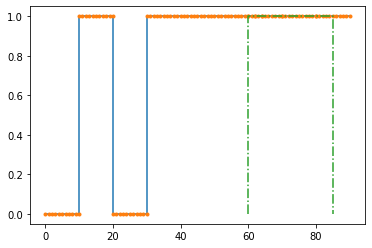

CASE: 7


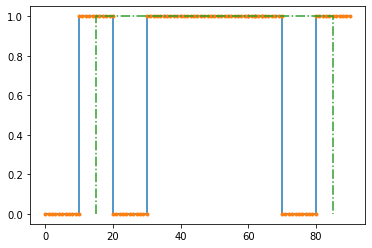

idx=0, pulse=-10, t_start=15, t_width=70
idx=1, pulse=10, t_start=5, t_width=70
duration=10, t_width=70, delay=-5, t_start=5
Positive pulse overlap of -5
idx=2, pulse=-10, t_start=0, t_width=65
duration=10, t_width=65, delay=-10, t_start=0
Adding +++ pulse
idx=3, pulse=30, t_start=0, t_width=55
duration=30, t_width=55, delay=-30, t_start=0
Positive pulse overlap of -30
idx=4, pulse=nested_pulse_train( [ 2, 2, 6, -10, ] ) , t_start=0, t_width=25
Recursive call of add_pulse(0,25)
idx=0, pulse=2, t_start=0, t_width=25
duration=2, t_width=25, delay=-2, t_start=0
Positive pulse overlap of -2
idx=1, pulse=2, t_start=0, t_width=23
duration=2, t_width=23, delay=-2, t_start=0
Positive pulse overlap of -2
idx=2, pulse=6, t_start=0, t_width=21
duration=6, t_width=21, delay=-6, t_start=0
Positive pulse overlap of -6
idx=3, pulse=-10, t_start=0, t_width=15
duration=10, t_width=15, delay=-10, t_start=0
Adding +++ pulse
idx=5, pulse=10, t_start=0, t_width=5
duration=10, t_width=5, delay=-10, t_start=

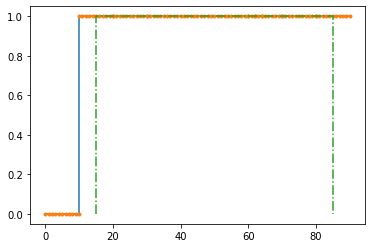

In [228]:
train = nested_pulse_train( [-10,10,-10,30, nested_pulse_train([2,2,6,-10]),10 ]  )

cases=[]
cases.append( (20,5) )
cases.append( (25,3) )
cases.append( (25,5) )
cases.append( (19,11) )
cases.append( (40,5) )
cases.append( (60,15) )
cases.append( (60,25) )
cases.append( (15,70) )

"""
Cases to verify:

0) New pulse is entirely between existing pulses
1) New pulse overlaps previous pulse
    1') adjacent
2) New pulse overlaps next pulse
    2') adjacent
3) New pulse overlaps both previous and preceeding pulse
    3') adjacent

4) New pulse is entirely contained within existing pulse
    4') adjacent
    *) Pulse train is unchanged
5) Pulse start is beyond scope of current buffer
6) Pulse start is within scope, but stop is beyond scope

7) All cases with either current_state = 0 or current_state = 1

"""


"""
*) directly adjacent edges should be considered overlapping, with 0 width
*)  classify cases based on whether new pulses' rising and falling edges:
        *) lie within existing pulses
        *) lie within dead zones
        *) lie within the same existing pulses
        *) lie within the same dead zone
"""



for (idx, case) in enumerate(cases):
    train = nested_pulse_train( [-10,10,-10,30, nested_pulse_train([2,2,6,-10]),10 ] ,verbose = True )
    
    print(f"CASE: {idx}")
    #unpack the case
    t_start = case[0]
    t_width = case[1]
    
    #Plot the existsing pulse stream and the desired new pulse
    ts,expanded = train.expand()
    plt.plot(ts,expanded)
    plt.plot(ts,expanded,".")
    ts_new, expanded_new = expand_new_pulse(t_start,t_width)
    plt.plot(ts_new,expanded_new,"-.") 
    plt.show()
    
    
    train.add_pulse(t_start,t_width)
    ts,expanded = train.expand()
    plt.plot(ts,expanded)
    plt.plot(ts,expanded,".")
    plt.plot(ts_new,expanded_new,"-.") 
    plt.show()

In [51]:
np.argmax(np.where(cum_sum<t_start))

3

In [ ]:
previous_pulse_end_idx = j-1-((j%2)-1)*start
print(f"{previous_pulse_end_idx=}")
preceeding_gap = t_start-cum_sum[previous_pulse_end_idx]
if preceeding_gap > 0:
    print(f"new pulse begins at {t_start}, which is {preceeding_gap} after the end of the previous pulse ({cum_sum[previous_pulse_end_idx]})")
elif preceeding_gap < -t_width:
    print(f"CASE 5: new_pulse is entirely within existing pulse!")
else:
    print(f"new_pulse begins at {t_start}, which overlaps with previous pulse by {preceeding_gap}")
    
next_pulse_begin_idx = j-(j%2+start)
print(f"{next_pulse_begin_idx=}")
following_gap = cum_sum[next_pulse_begin_idx]-(t_start+t_width)
if following_gap > 0:
    print(f"New pulse ends at {t_start+t_width}, which is {following_gap} before the following pulse begins ({cum_sum[next_pulse_begin_idx]})") 
else:
    print(f"New pulse ends at {t_start+t_width}, which overlaps with the following pulse by {following_gap}")

    
if (preceeding_gap > 0) and (following_gap > 0):
    print("CASE 1: No overlap between new pulse and existing pulses")

elif (preceeding_gap <=0) and (following_gap > 0):
    print("CASE 2: new pulse overlaps previous pulse but not following pulse")

elif (preceeding_gap >0) and (following_gap <=0):
    print("CASE 3: new pulse overlaps following pulse but not previous pulse")

elif (preceeding_gap <=0) and (following_gap<=0):
    print("CASE 4: New pulse bridges two previous pulses")

In [48]:
cum_sum[j]

20